# Preprocessing



In [39]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import monotonically_increasing_id, col, rand, when 
from pyspark.ml.feature import Bucketizer

In [2]:
spark = SparkSession.builder.master("local[*]").appName("AutoIncrementIDWithRandom").getOrCreate()

24/07/10 11:34:37 WARN Utils: Your hostname, pengfei-Virtual-Machine resolves to a loopback address: 127.0.1.1; using 10.50.2.80 instead (on interface eth0)
24/07/10 11:34:37 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/07/10 11:34:38 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [26]:
# Number of rows you want in the DataFrame
small_s = 0
small_e = 10000
# Create an initial DataFrame with the desired number of rows
df_small = spark.range(small_s, small_e).toDF("id")

# Add a column with random integers between 1 and 10,000,000
df_small = df_small.withColumn("file_size", (rand() * 100).cast("int") + 1)

# Show the DataFrame
df_small.show(5)

+---+---------+
| id|file_size|
+---+---------+
|  0|       91|
|  1|       17|
|  2|       32|
|  3|       40|
|  4|       49|
+---+---------+
only showing top 5 rows



In [27]:
# Number of rows you want in the DataFrame
median_s = small_e+1
median_e = median_s+2500

# Create an initial DataFrame with the desired number of rows
df_median = spark.range(median_s, median_e).toDF("id")

# 
df_median = df_median.withColumn("file_size", (rand() * 500).cast("int") + 1)

# Show the DataFrame
df_median.show(5)

+-----+---------+
|   id|file_size|
+-----+---------+
|10001|       63|
|10002|       12|
|10003|      296|
|10004|      296|
|10005|      255|
+-----+---------+
only showing top 5 rows



In [28]:
# Number of rows you want in the DataFrame
large_s = median_e+1
large_e = large_s+5000

# Create an initial DataFrame with the desired number of rows
df_large = spark.range(large_s, large_e).toDF("id")

# 
df_large = df_large.withColumn("file_size", (rand() * 900).cast("int") + 1)

# Show the DataFrame
df_large.show(5)

+-----+---------+
|   id|file_size|
+-----+---------+
|12502|      746|
|12503|      745|
|12504|      123|
|12505|      783|
|12506|       73|
+-----+---------+
only showing top 5 rows



In [29]:
df=df_small.union(df_median)
df=df.union(df_large)

In [33]:
df.select("file_size").describe().show()

+-------+------------------+
|summary|         file_size|
+-------+------------------+
|  count|             17500|
|   mean|          193.8324|
| stddev|232.35070564983883|
|    min|                 1|
|    max|               900|
+-------+------------------+



In [30]:
file_sizes=df.select("file_size").rdd.flatMap(lambda x:x).collect()

In [31]:
print(file_sizes)

[91, 17, 32, 40, 49, 12, 14, 61, 1, 24, 96, 38, 54, 79, 62, 48, 99, 30, 88, 12, 86, 51, 82, 66, 52, 55, 6, 40, 69, 54, 69, 66, 94, 36, 23, 12, 26, 6, 13, 9, 5, 33, 83, 72, 41, 6, 100, 51, 48, 8, 72, 66, 22, 18, 17, 29, 4, 6, 92, 59, 84, 8, 84, 32, 80, 24, 45, 6, 96, 65, 66, 10, 43, 18, 17, 56, 61, 29, 97, 61, 31, 78, 38, 95, 99, 94, 1, 72, 96, 4, 61, 12, 10, 90, 12, 24, 67, 6, 58, 19, 5, 98, 23, 10, 96, 76, 2, 94, 25, 2, 75, 22, 21, 18, 76, 28, 95, 65, 7, 58, 49, 89, 36, 1, 36, 26, 26, 47, 85, 88, 13, 39, 64, 34, 35, 63, 6, 82, 36, 37, 36, 37, 27, 78, 9, 85, 77, 55, 21, 7, 28, 49, 30, 93, 32, 27, 21, 9, 48, 65, 45, 50, 44, 58, 27, 47, 77, 17, 89, 64, 58, 82, 14, 6, 5, 78, 98, 86, 8, 36, 10, 72, 9, 66, 8, 23, 66, 67, 62, 37, 32, 54, 3, 35, 9, 41, 10, 100, 65, 18, 48, 20, 19, 31, 82, 29, 66, 75, 37, 72, 85, 56, 9, 99, 100, 90, 45, 20, 6, 23, 40, 12, 75, 83, 42, 84, 71, 11, 28, 2, 59, 15, 26, 16, 57, 62, 26, 19, 10, 26, 33, 78, 44, 32, 60, 88, 54, 94, 98, 78, 34, 86, 70, 79, 19, 75, 61, 7

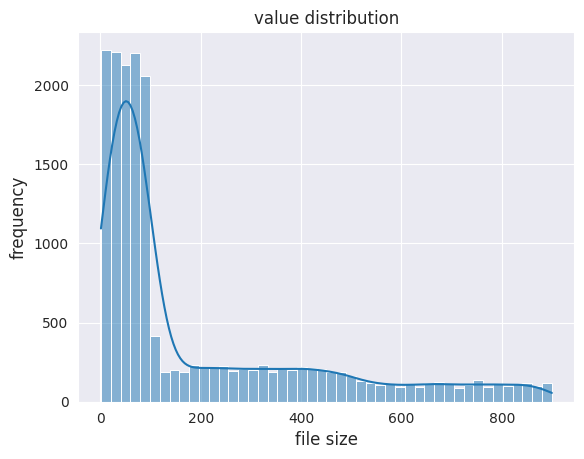

In [32]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
sns.histplot(file_sizes, kde=True) # 以第一个变量为例
ax.set_title('value distribution', fontsize=12)
ax.set_xlabel('file size', fontsize=12)
ax.set_ylabel('frequency', fontsize=12); # 这个变量为长尾分布

## Uniform Binning

let's try manual binning first

We can define how to cut the bucket with arbitrary value

With the above stat, we know the min value is `1`, and the max is `900`.

In the first example, we divide it into three bin: (1,300),(301,600),(601,900)

In [38]:
df_three_bin=df.withColumn("bin_cat", 
                           when((col("file_size")>=1) & (col("file_size")<=300),"small") \
                           .when((col("file_size")>=301) & (col("file_size")<=600),"median") \
                           .when((col("file_size")>=601) & (col("file_size")<=900),"large") \
                           .otherwise("error"))

df_three_bin.show(5)
df_three_bin.groupby("bin_cat").count().show()

+---+---------+-------+
| id|file_size|bin_cat|
+---+---------+-------+
|  0|       91|  small|
|  1|       17|  small|
|  2|       32|  small|
|  3|       40|  small|
|  4|       49|  small|
+---+---------+-------+
only showing top 5 rows

+-------+-----+
|bin_cat|count|
+-------+-----+
|  small|13154|
| median| 2664|
|  large| 1682|
+-------+-----+



## spark Bucketizer

In [41]:
splits = [-float("inf"), 300.0, 600.0, float("inf")]
bucketizer = Bucketizer(splits=splits, inputCol="file_size", outputCol="bin_cat")

# Apply Bucketizer to the DataFrame
df_buck_bin = bucketizer.transform(df)

In [42]:
df_buck_bin.show(5)
df_buck_bin.groupby("bin_cat").count().show()

+---+---------+-------+
| id|file_size|bin_cat|
+---+---------+-------+
|  0|       91|    0.0|
|  1|       17|    0.0|
|  2|       32|    0.0|
|  3|       40|    0.0|
|  4|       49|    0.0|
+---+---------+-------+
only showing top 5 rows



+-------+-----+
|bin_cat|count|
+-------+-----+
|    0.0|13146|
|    1.0| 2667|
|    2.0| 1687|
+-------+-----+



## Scikit learn KBinsDiscretizer



In [48]:
from sklearn.preprocessing import KBinsDiscretizer
import numpy as np

# as sklearn model only takes [[]..[]] data type as input, we need to first
# convert the dataframe to a np array, then reshape it to [[]..[]]
df_train, df_test = df.randomSplit([0.9,0.1],seed=38)
train_set = np.array(df_train.select("file_size").rdd.flatMap(lambda x:x).collect()).reshape(-1,1) 
test_set = np.array(df_test.select("file_size").rdd.flatMap(lambda x:x).collect()).reshape(-1,1)

In [62]:
# build a KBinsDiscretizer
sk_equ_interval = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='uniform',subsample=None) # set 3 bins

# 
sk_equ_interval.fit(train_set)

# transform the test set
transformed_test = sk_equ_interval.transform(test_set.reshape(-1,1)).reshape(-1) 

# let's check how the bin is divided
equ_interval_bin_edge = sk_equ_interval.bin_edges_[0]



In [63]:

for edge in equ_interval_bin_edge:
    print(edge)

1.0
300.6666666666667
600.3333333333334
900.0


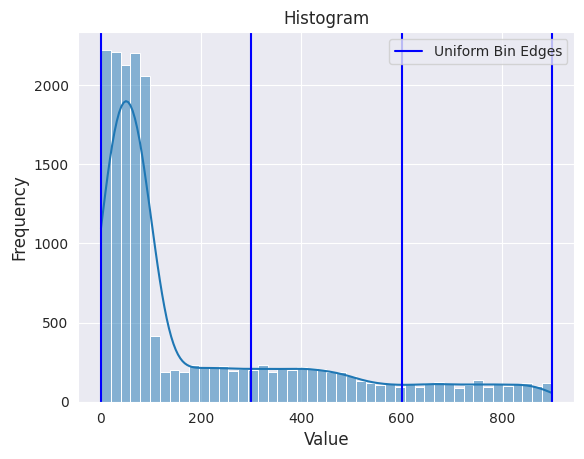

In [54]:
# visualize the bin edges
fig, ax = plt.subplots()
sns.histplot(file_sizes, kde=True)

for edge in equ_interval_bin_edge: # uniform bins
    line = plt.axvline(edge, color='b')
ax.legend([line], ['Uniform Bin Edges'], fontsize=10)
ax.set_title('Histogram', fontsize=12)
ax.set_xlabel('Value', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12); 

## Equal count binning


In [55]:

# build a KBinsDiscretizer
sk_equ_count = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='quantile',subsample=None) # set 3 bins

# train the model
sk_equ_count.fit(train_set)

# transform the test set
transformed_test = sk_equ_count.transform(test_set.reshape(-1,1)).reshape(-1) 

# let's check how the bin is divided
equ_count_bin_edge = sk_equ_count.bin_edges_[0]

In [57]:
for edge in equ_count_bin_edge:
    print(edge)

1.0
53.0
160.0
900.0


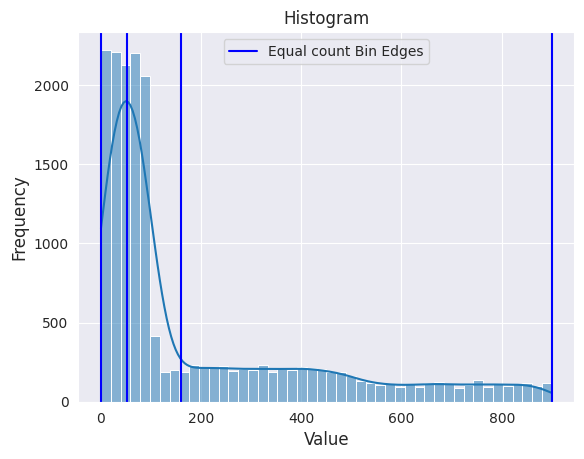

In [56]:
# visualize the bin edges
fig, ax = plt.subplots()
sns.histplot(file_sizes, kde=True)

for edge in equ_count_bin_edge: # uniform bins
    line = plt.axvline(edge, color='b')
ax.legend([line], ['Equal count Bin Edges'], fontsize=10)
ax.set_title('Histogram', fontsize=12)
ax.set_xlabel('Value', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12); 

## Kmeans 

In [58]:
# build a KBinsDiscretizer
sk_kmeans = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='kmeans',subsample=None) # set 3 bins

# train the model
sk_kmeans.fit(train_set)

# transform the test set
transformed_test = sk_kmeans.transform(test_set.reshape(-1,1)).reshape(-1) 

# let's check how the bin is divided
kmeans_bin_edge = sk_kmeans.bin_edges_[0]

In [59]:
for edge in kmeans_bin_edge:
    print(edge)

1.0
217.4420081872612
549.0732641332401
900.0


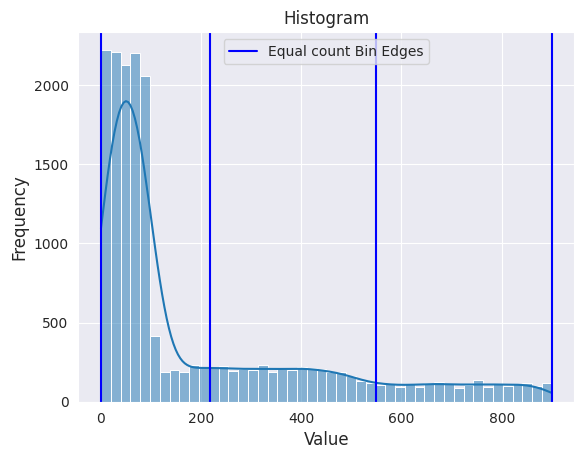

In [60]:
# visualize the bin edges
fig, ax = plt.subplots()
sns.histplot(file_sizes, kde=True)

for edge in kmeans_bin_edge:
    line = plt.axvline(edge, color='b')
ax.legend([line], ['Equal count Bin Edges'], fontsize=10)
ax.set_title('Histogram', fontsize=12)
ax.set_xlabel('Value', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12); 